# Traffic Analysis

- Develop metrics for average trip speeds to analyze traffic conditions.
- Compare speeds for trips covering similar distances and categorize these by time variables.

## Part 1: Develope the job locally

### Step 1. Setup the environment

In [1]:
from pyspark.sql import SparkSession

# Create or retrieve a Spark session
spark = SparkSession.builder.appName("Traffic Analysis").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 18:40:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Step 2. Load the processed data

In [2]:
TRAIN_PROCESSED = "../../data/processed/train_processed.parquet"

df = spark.read.parquet(TRAIN_PROCESSED)

In [5]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- trip_distance_km: double (nullable = true)



### Step 3. Data preparation

We calculate the trip speed as distance (in km) divided by duration (in hours)

In [6]:
from pyspark.sql.functions import col

# Ensure that trip_duration is in hours if it's not already. If trip_duration is in seconds, convert it.
df = df.withColumn("duration_hours", col("trip_duration") / 3600)

# Calculate speed in km/h
df = df.withColumn("trip_speed_km_per_hr", col("trip_distance_km") / col("duration_hours"))


In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_dayofweek: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- trip_distance_km: double (nullable = true)
 |-- duration_hours: double (nullable = true)
 |-- trip_speed_km_per_hr: double (nullable = true)



### Step 4: Develop Metrics for Average Trip Speeds

Calculate average speeds and standard deviations grouped by various time slices:

In [8]:
from pyspark.sql.functions import hour, dayofweek, month, avg, stddev

# Extract time components
df = df.withColumn("hour", hour("pickup_datetime"))
df = df.withColumn("day_of_week", dayofweek("pickup_datetime"))
df = df.withColumn("month", month("pickup_datetime"))

# Group by time components and calculate average speed and standard deviation
speed_stats = df.groupBy("hour", "day_of_week", "month").agg(
    avg("trip_speed_km_per_hr").alias("avg_speed"),
    stddev("trip_speed_km_per_hr").alias("speed_stddev")
).orderBy("day_of_week", "hour", "month")

speed_stats.show()


+----+-----------+-----+------------------+------------------+
|hour|day_of_week|month|         avg_speed|      speed_stddev|
+----+-----------+-----+------------------+------------------+
|   0|          1|    1| 16.14966189330342| 8.254841100551094|
|   0|          1|    2|15.457664462532627| 7.502795372055547|
|   0|          1|    3|15.648980965899712| 7.518083293184715|
|   0|          1|    4|15.421758744612129| 7.542561556297256|
|   0|          1|    5|15.664749397577744| 7.793421793672584|
|   0|          1|    6| 15.32061307059771| 7.521405235099395|
|   1|          1|    1| 17.11957528337382| 8.510952718755314|
|   1|          1|    2|16.419019945109675| 7.718718821992325|
|   1|          1|    3|16.450794464404417|13.088370414725974|
|   1|          1|    4| 16.49108503313661| 7.613377731991213|
|   1|          1|    5|16.626823074224045| 7.874163199720947|
|   1|          1|    6|16.545623249272055| 7.904440207112059|
|   2|          1|    1|17.700932478219944| 8.228461935

### Step 5: Analyze Traffic Based on Trip Distances

In [9]:
from pyspark.sql.functions import when

# Define distance categories
df = df.withColumn("distance_category",
                   when(col("trip_distance_km") <= 2, "Short (<2km)")
                   .when((col("trip_distance_km") > 2) & (col("trip_distance_km") <= 5), "Medium (2-5km)")
                   .otherwise("Long (>5km)"))

# Calculate average speed for each distance category
distance_speed_stats = df.groupBy("distance_category").agg(
    avg("trip_speed_km_per_hr").alias("avg_speed_by_dist")
)

distance_speed_stats.show()


+-----------------+------------------+
|distance_category| avg_speed_by_dist|
+-----------------+------------------+
|      Long (>5km)| 22.46737952979779|
|     Short (<2km)|11.450601056430306|
|   Medium (2-5km)|14.342252633488304|
+-----------------+------------------+



### Step 6: Visualization
To better understand the patterns, we visualize the results 

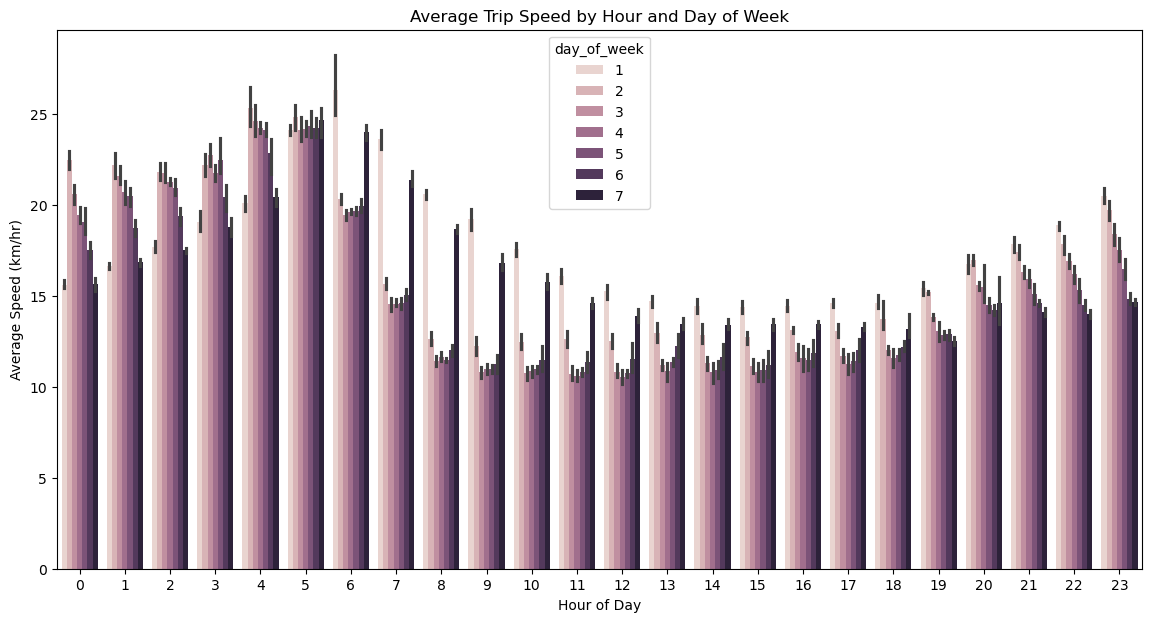

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pd_speed_stats = speed_stats.toPandas()

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(x="hour", y="avg_speed", hue="day_of_week", data=pd_speed_stats)
plt.title("Average Trip Speed by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Average Speed (km/hr)")
plt.show()

### Step 7. Clean up

In [11]:
spark.stop()

### Step 8. Convert to .py script

In [12]:
!jupyter nbconvert --to script ./traffic_analysis.ipynb


[NbConvertApp] Converting notebook ./traffic_analysis.ipynb to script
[NbConvertApp] Writing 3056 bytes to traffic_analysis.py


## Part 2: Running on GCP Cloud Dataproc

Before running the cell below, make sure to test the script with the local environment first then editing the folder's path corresponding to the folder structure on Google Cloud Bucket.

In [24]:
# Set bucket name
bucket_name = "spbd-nyc-taxi-bucket"


# Upload the Python script
!gsutil cp ./traffic_analysis.py gs://{bucket_name}/scripts/

# Upload processed data
# !gsutil -m cp -r ../../data/processed/train_processed.parquet gs://{bucket_name}/data/


Copying file://./traffic_analysis.py [Content-Type=text/x-python]...
/ [1 files][  2.8 KiB/  2.8 KiB]                                                
Operation completed over 1 objects/2.8 KiB.                                      


### Create a new cluster if not existed

In [31]:
cluster_name = "spbd-nyc-taxi-cluster"
region = "europe-west9"
machine_type="n2-standard-2"

!gcloud dataproc clusters create {cluster_name} \
    --region={region} \
    --zone={region}-a \
    --master-machine-type={machine_type} \
    --worker-machine-type={machine_type} \
    --num-workers=2 \
    --image-version=2.0-debian10 \
    --scopes=default


Waiting on operation [projects/epita-spbd-nyc-da/regions/europe-west9/operations/cdff4b7d-7c48-3ad9-82b5-b70e7b733c42].
Waiting for cluster creation operation...                                      
Waiting for cluster creation operation...done.                                 
Created [https://dataproc.googleapis.com/v1/projects/epita-spbd-nyc-da/regions/europe-west9/clusters/spbd-nyc-taxi-cluster] Cluster placed in zone [europe-west9-a].


### Now, submit our Spark Job

In [32]:
!gcloud dataproc jobs submit pyspark \
    gs://spbd-nyc-taxi-bucket/scripts/traffic_analysis.py \
    --cluster={cluster_name} \
    --region={region}

Job [8395f1badd5e4f4dbae5cad95da9a51e] submitted.
Waiting for job output...
24/05/22 20:37:25 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/22 20:37:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/22 20:37:25 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/05/22 20:37:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/22 20:37:26 INFO org.sparkproject.jetty.util.log: Logging initialized @9867ms to org.sparkproject.jetty.util.log.Slf4jLog
24/05/22 20:37:26 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_412-b08
24/05/22 20:37:26 INFO org.sparkproject.jetty.server.Server: Started @10005ms
24/05/22 20:37:26 INFO org.sparkproject.jetty.server.AbstractConnector: Started ServerConnector@764fe8e9{HTTP/1.1, (http/1.1)}{0.0.0.0:43549}
24/05/22 20:37:27 INFO org.apache.hadoop.yarn.client.RMPr

### Monitor the Job Execution

In [34]:
!gcloud dataproc jobs list --cluster=spbd-nyc-taxi-cluster --region=europe-west9

JOB_ID                            TYPE     STATUS
8395f1badd5e4f4dbae5cad95da9a51e  pyspark  DONE


### Accessing Logs and Debugging

In [35]:
!gcloud logging read "resource.type=cloud_dataproc_cluster AND resource.labels.cluster_name=spbd-nyc-taxi-cluster" --limit 30 --format "value(textPayload)"

### (Optional) Delete a cluster

In [36]:
!gcloud dataproc clusters delete spbd-nyc-taxi-cluster --region=europe-west9 --quiet

Waiting on operation [projects/epita-spbd-nyc-da/regions/europe-west9/operations/8aa404b4-2131-30e5-9cee-cd4bf9f3454a].
Waiting for cluster deletion operation...done.                                 
Deleted [https://dataproc.googleapis.com/v1/projects/epita-spbd-nyc-da/regions/europe-west9/clusters/spbd-nyc-taxi-cluster].
